# modeling imputed values

So I found out a few things while doing the final homework, the most important being how PyMC handles imputed values. It turns out that we have to use masked values without data containers, or it work as expected. Secondly, there's an interesting method for handling missing data not at random. Here, we have to take into account the distributional properties of our dataset to make reasonable assumptions.

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)

In [10]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from birdcall_distribution.geo import (
    get_western_us_geometry,
    generate_grid,
    add_lonlat_columns,
    generate_grid_adjaceny_list,
    WESTERN_US_EXTENT,
    get_adjacency_mapping,
    convert_to_adjacency_matrix,
)
from sklearn.preprocessing import StandardScaler


# dataset with our data from earth engine
ee_df = pd.read_parquet("../data/ee_v3_western_us_2.parquet")
grid_size = ee_df.grid_size.values[0]

geometry = get_western_us_geometry()
grid = generate_grid(geometry, WESTERN_US_EXTENT, (grid_size, grid_size))
adjacency_list = generate_grid_adjaceny_list(grid)
mapping = get_adjacency_mapping(adjacency_list)
W = convert_to_adjacency_matrix(adjacency_list)

# pull out species and longitude/latitude data from the kaggle dataset
df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
df = df[["primary_label", "latitude", "longitude"]].dropna()
df = add_lonlat_columns(df, grid)
df = df[df.grid.notnull()]
df["adjacency_idx"] = df.grid_id.apply(lambda x: mapping.get(x, None))

# count number of observed calls per adjacency index, and join against the ee variables
counts_df = df.grid_id.value_counts().reset_index()
counts_df.columns = ["grid_id", "y"]
prep_df = counts_df.merge(
    ee_df.rename(columns={"name": "grid_id"}), on="grid_id", how="outer"
)
prep_df["adjacency_idx"] = prep_df.grid_id.apply(lambda x: mapping.get(x, None))
prep_df = prep_df.set_index("adjacency_idx").sort_index()
prep_df

,grid_id,y,region,grid_size,population_density,elevation_p5,elevation_p50,elevation_p95,LST_Day_1km_p5,LST_Day_1km_p50,...,land_cover_08,land_cover_09,land_cover_10,land_cover_11,land_cover_12,land_cover_13,land_cover_14,land_cover_15,land_cover_16,land_cover_17
adjacency_idx,,,,,,,,,,,,,,,,,,,,,
0,-103_37,14.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,28.009886,...,0,0,25124,0,13749,9,0,0,10,10
1,-103_39,15.0,western_us,2,7.231147e+04,933.400010,1109.527419,1373.500000,23.530828,26.249684,...,0,0,26593,1,11191,14,0,0,5,5
2,-103_41,NaN,western_us,2,5.298306e+04,953.464499,1125.457914,1241.526139,21.852460,23.850834,...,0,0,35137,3,1610,14,0,0,18,64
3,-105_31,6.0,western_us,2,1.849136e+05,811.383023,1083.550054,1571.236367,29.610085,34.010337,...,0,0,8989,0,402,46,0,0,1788,2
4,-105_33,1.0,western_us,2,1.702256e+05,1113.531792,1305.404926,1549.361996,29.690626,31.608933,...,0,0,32035,0,1947,46,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-125_39,28.0,western_us,2,3.132453e+05,0.088013,71.273196,1255.422819,15.928846,20.011954,...,3629,591,546,58,19,76,0,0,2,2087
92,-125_41,2.0,western_us,2,2.742128e+05,0.121369,407.641823,1447.500509,15.403725,18.289943,...,1649,279,215,36,21,58,2,0,1,2822
93,-125_43,13.0,western_us,2,1.296667e+06,0.055965,83.426425,531.368421,14.331732,17.050456,...,1220,298,245,61,1961,338,60,0,10,2982


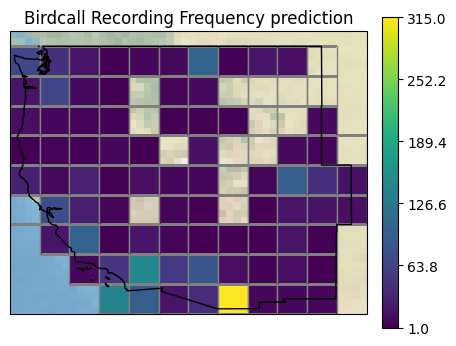

In [57]:
from birdcall_distribution.plot import dataframe_color_getter, plot_grid
from functools import partial

prop = "y"

plot_grid(
    geometry,
    WESTERN_US_EXTENT,
    grid,
    color_callback=partial(dataframe_color_getter, prep_df, "grid_id", prop),
    vmin=prep_df[prop].min(),
    vmax=prep_df[prop].max(),
    draw_gridline=False,
    figsize=(5, 7),
)

plt.title("Birdcall Recording Frequency prediction")
plt.show()

In [86]:
def plot_ppc(prep_df, ppc, prop="log_pred"):
    shape = prep_df.shape
    pred = ppc.posterior_predictive.y.values.reshape(-1, shape[0]).mean(axis=0)
    pred_df = pd.DataFrame({"pred": pred})
    pred_df["adjacency_idx"] = pred_df.index
    pred_df = pred_df.set_index("adjacency_idx").join(prep_df[["grid_id"]])
    # log prediction
    pred_df["log_pred"] = np.log(pred_df.pred)

    plt.figure(figsize=(5, 3))
    plt.hist(pred_df[prop], bins=20)
    plt.title(f"histogram of {prop}")
    plt.show()

    # plot the posterior predictive
    plot_grid(
        geometry,
        WESTERN_US_EXTENT,
        grid,
        color_callback=partial(dataframe_color_getter, pred_df, "grid_id", prop),
        vmin=pred_df[prop].min(),
        vmax=pred_df[prop].max(),
        draw_gridline=False,
        figsize=(5, 7),
    )
    plt.title("Birdcall Recording Frequency prediction")
    plt.show()

## mean model

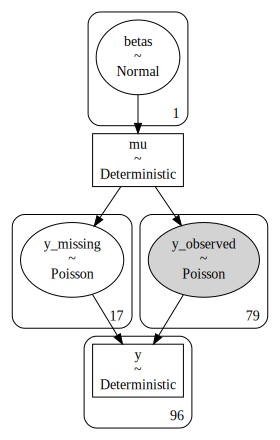

In [121]:
with pm.Model() as mean_model:
    # simple mean model using a poisson regression with no spatial structure
    betas = pm.Normal("betas", sigma=1e3, shape=1)
    mu = pm.Deterministic("mu", pm.math.exp(betas[0]))
    pm.Poisson("y", mu=mu, observed=np.ma.masked_invalid(prep_df.y.values))

pm.model_to_graphviz(mean_model)

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>NUTS: [betas]
>Metropolis: [y_missing]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%
betas[0],3.259,0.023,3.217,3.302
y_missing[0],25.921,6.094,15.000,37.000
y_missing[1],26.282,6.078,15.000,37.000
y_missing[2],26.287,6.124,15.000,37.000
y_missing[3],26.141,6.215,15.000,37.000
y_missing[4],26.377,6.147,15.000,37.000
y_missing[5],26.152,6.062,15.000,37.000
y_missing[6],26.427,6.188,15.000,37.000
y_missing[7],26.153,6.100,15.000,37.000
y_missing[8],26.484,6.263,15.000,37.000


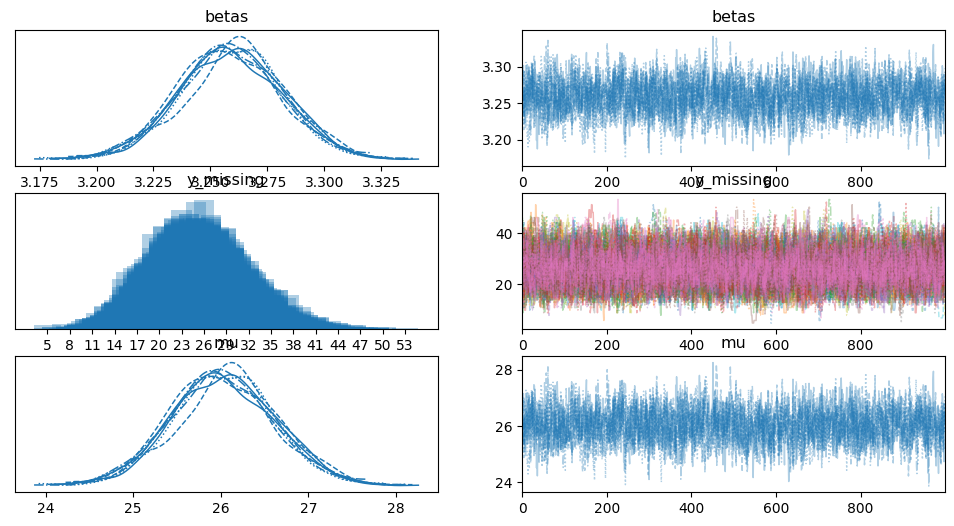

In [122]:
with mean_model:
    trace_mean_model = pm.sample(1000, cores=8)

az.plot_trace(trace_mean_model)
az.summary(trace_mean_model, kind="stats")

Sampling: [y_observed]


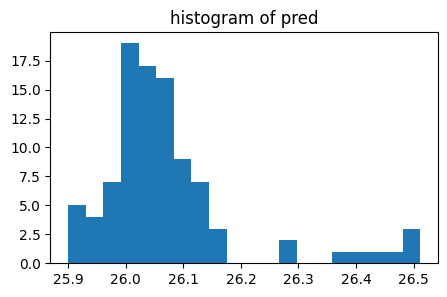

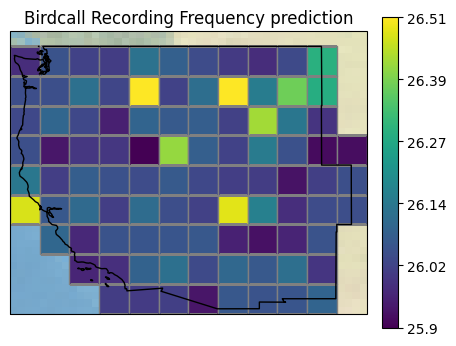

In [124]:
with mean_model:
    ppc_mean_model = pm.sample_posterior_predictive(trace_mean_model)

plot_ppc(prep_df, ppc_mean_model, "pred")

## mean model with spatial random effects

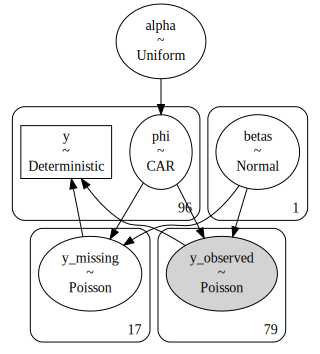

In [135]:
# simple mean model with spatial structure
with pm.Model() as mean_spatial_model:
    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-4, alpha=alpha, W=W)

    betas = pm.Normal("betas", tau=1e-4, shape=1)
    # NOTE: we can't make this deterministic, lest we get a shape error.
    # this is due to how the imputation works in pymc
    mu = pm.math.exp(betas[0] + phi[prep_df.index.values])
    pm.Poisson("y", mu=mu, observed=np.ma.masked_invalid(prep_df.y.values))

pm.model_to_graphviz(mean_spatial_model)

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>NUTS: [alpha, phi, betas]
>Metropolis: [y_missing]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 135 seconds.


,mean,sd,hdi_3%,hdi_97%
phi[0],5.251,5.551,-3.439,17.177
phi[1],5.325,5.551,-3.536,17.083
phi[2],-35.306,30.234,-93.852,8.558
phi[3],4.358,5.567,-4.489,16.137
phi[4],2.056,5.656,-7.627,13.268
...,...,...,...,...
y_missing[13],1.373,5.665,0.000,6.000
y_missing[14],0.899,3.238,0.000,8.000
y_missing[15],0.175,0.996,0.000,0.000
y_missing[16],0.354,1.906,0.000,0.000


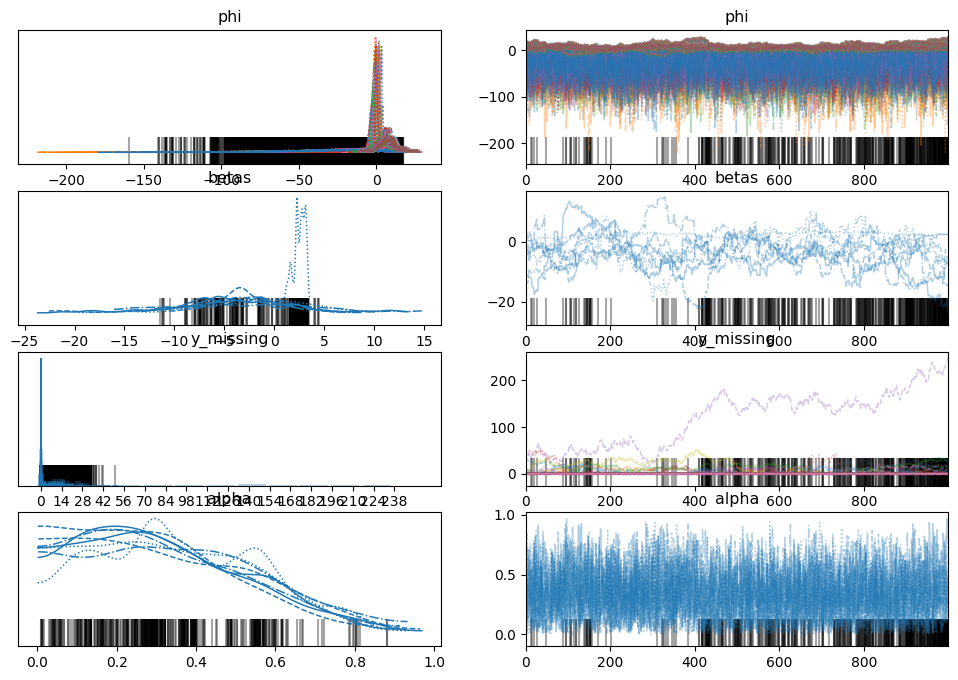

In [129]:
with mean_spatial_model:
    trace_mean_spatial = pm.sample(1000, cores=8, target_accept=0.9)

az.plot_trace(trace_mean_spatial)
az.summary(trace_mean_spatial, kind="stats")

Sampling: [y_observed]


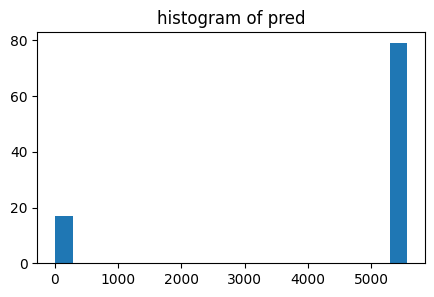

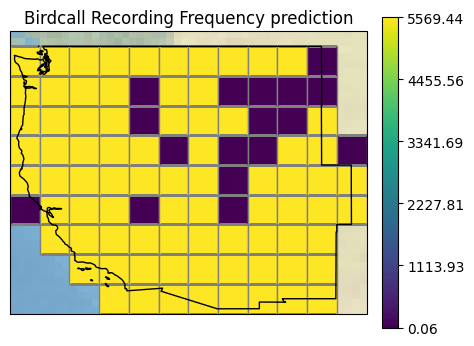

In [132]:
with mean_model:
    ppc_mean_spatial = pm.sample_posterior_predictive(trace_mean_spatial)

plot_ppc(prep_df, ppc_mean_spatial, "pred")

## heiarchical mean model with spatial random effects

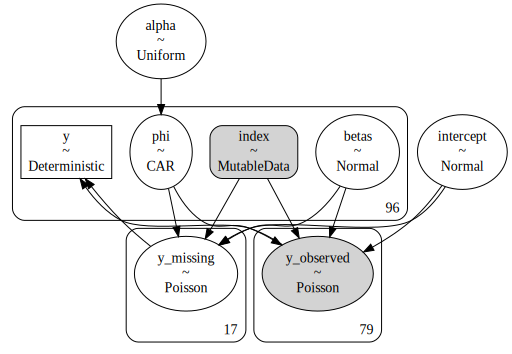

In [137]:
with pm.Model() as grouped_mean_model:
    index = pm.MutableData("index", prep_df.index.values)
    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-4, alpha=alpha, W=W)

    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    betas = pm.Normal("betas", tau=1e-4, shape=prep_df.shape[0])
    mu = pm.math.exp(intercept + betas[index] + phi[index])
    pm.Poisson("y", mu=mu, observed=np.ma.masked_invalid(prep_df.y.values))

pm.model_to_graphviz(grouped_mean_model)

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>NUTS: [alpha, phi, intercept, betas]
>Metropolis: [y_missing]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 297 seconds.


,mean,sd,hdi_3%,hdi_97%
phi[0],3.804,48.027,-83.238,97.529
phi[1],4.301,40.931,-71.949,78.906
phi[2],-9.884,49.201,-101.292,83.621
phi[3],3.233,51.799,-91.763,101.754
phi[4],1.583,43.329,-82.679,81.636
...,...,...,...,...
y_missing[13],0.023,0.278,0.000,0.000
y_missing[14],0.077,0.613,0.000,0.000
y_missing[15],0.098,0.756,0.000,0.000
y_missing[16],0.066,0.761,0.000,0.000


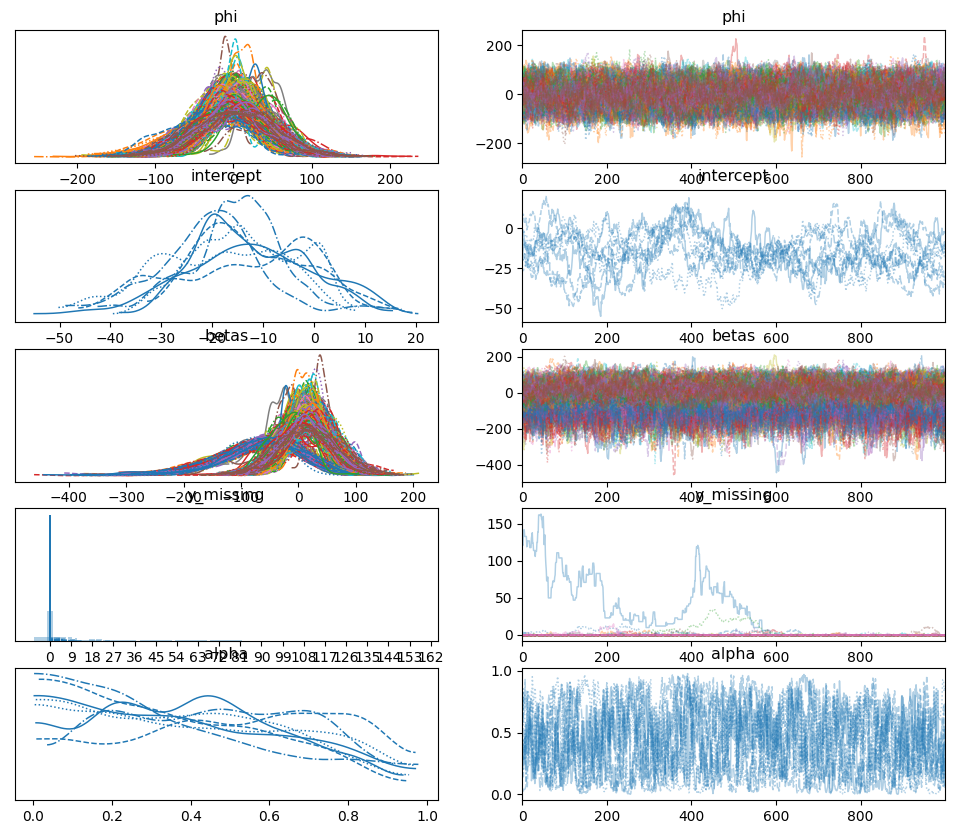

In [138]:
with grouped_mean_model:
    trace_grouped_mean = pm.sample(1000, cores=8, target_accept=0.9)

az.plot_trace(trace_grouped_mean)
az.summary(trace_grouped_mean, kind="stats")

In [201]:
az.summary(trace_grouped_mean, kind="stats", var_names=["~phi", "~betas"])

,mean,sd,hdi_3%,hdi_97%
intercept,-14.848,12.165,-36.936,8.842
y_missing[0],0.215,1.315,0.000,0.000
y_missing[1],0.029,0.293,0.000,0.000
y_missing[2],0.004,0.085,0.000,0.000
y_missing[3],0.055,0.465,0.000,0.000
y_missing[4],0.036,0.274,0.000,0.000
y_missing[5],0.003,0.071,0.000,0.000
y_missing[6],0.036,0.308,0.000,0.000
y_missing[7],0.010,0.136,0.000,0.000
y_missing[8],0.010,0.117,0.000,0.000


Sampling: [y_observed]


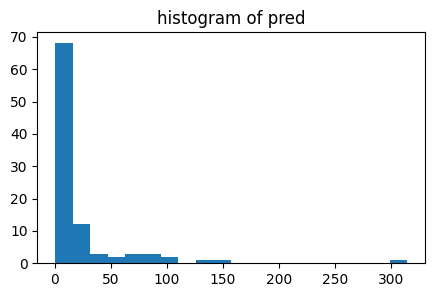

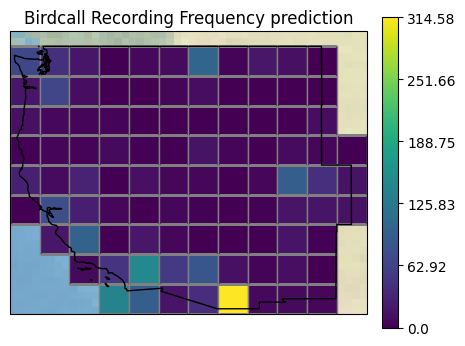

In [142]:
with grouped_mean_model:
    ppc_grouped_mean = pm.sample_posterior_predictive(trace_grouped_mean)

plot_ppc(prep_df, ppc_grouped_mean, "pred")

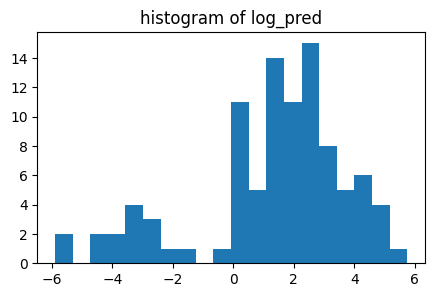

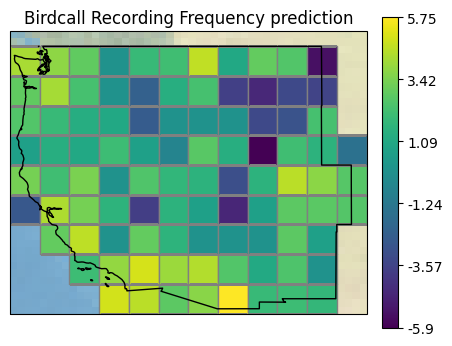

In [143]:
plot_ppc(prep_df, ppc_grouped_mean, "log_pred")

This is maybe the most reasonable plot that I've made so far.

# non-ignorable missingness

We'll apply some of the techniques for imputation. We assume that probability that a recording is taken is a function of the population density. Not sure this was actually useful at all?

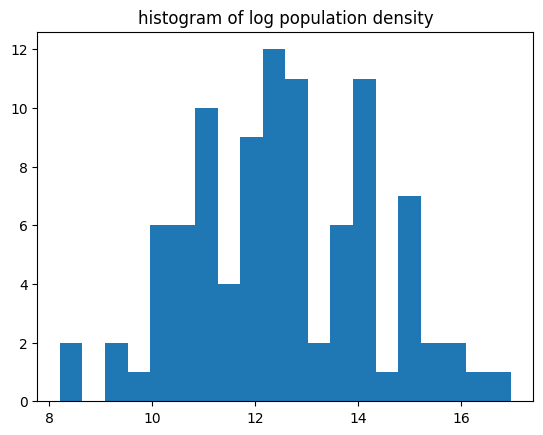

In [160]:
plt.hist(np.log(prep_df.population_density), bins=20)
plt.title("histogram of log population density")
plt.show()

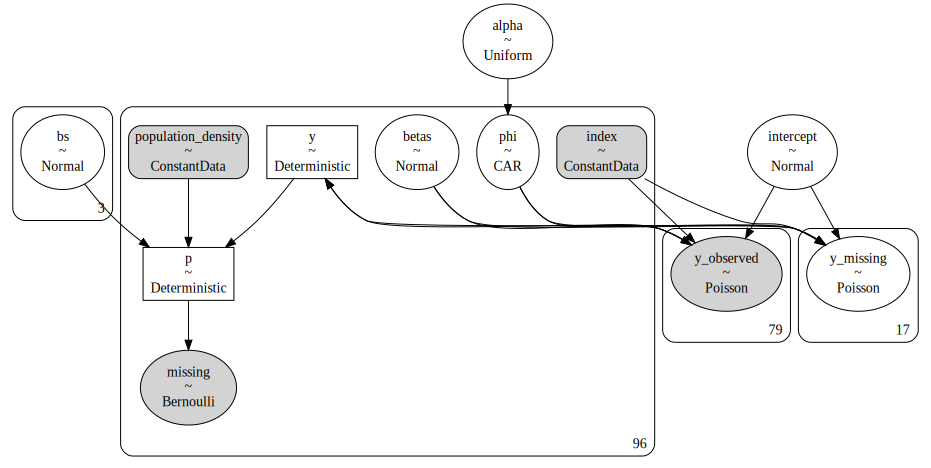

In [177]:
with pm.Model() as missing_model:
    index = pm.ConstantData("index", prep_df.index.values)
    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-4, alpha=alpha, W=W)

    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    betas = pm.Normal("betas", tau=1e-4, shape=prep_df.shape[0])
    mu = pm.math.exp(intercept + betas[index] + phi[index])

    observed = np.ma.masked_invalid(prep_df.y.values)
    y = pm.Poisson("y", mu=mu, observed=observed)

    # now we regress on the missingness of the data, which is related to the population density
    population_density = pm.ConstantData(
        "population_density", prep_df.population_density
    )
    bs = pm.Normal("bs", mu=0, tau=1e-4, shape=3)
    p = pm.Deterministic(
        "p", pm.math.invlogit(bs[0] + bs[1] * population_density + bs[2] * y)
    )
    pm.Bernoulli("missing", p=p, observed=observed.mask)

pm.model_to_graphviz(missing_model)

In [156]:
with missing_model:
    trace_missing = pm.sample(1000, cores=8, target_accept=0.9)

az.summary(trace_missing, kind="stats")

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>NUTS: [alpha, phi, intercept, betas, bs]
>Metropolis: [y_missing]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 406 seconds.
/mnt/fortis/omscs/bayes/birdcall-distribution/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%
phi[0],5.878,45.698,-80.365,89.996
phi[1],2.536,43.542,-77.917,83.362
phi[2],-16.941,49.027,-103.420,81.000
phi[3],0.291,50.807,-94.371,94.268
phi[4],3.344,40.678,-70.190,82.413
...,...,...,...,...
p[91],0.000,0.000,0.000,0.000
p[92],0.000,0.000,0.000,0.000
p[93],0.000,0.000,0.000,0.000
p[94],0.000,0.000,0.000,0.000


Sampling: [missing, y_observed]


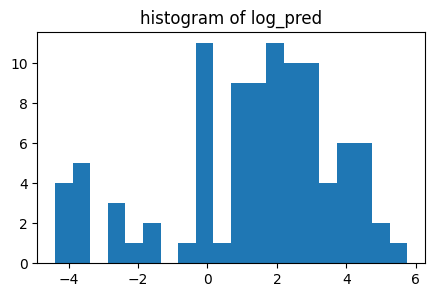

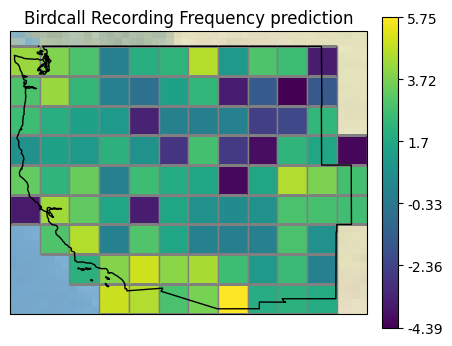

In [153]:
with missing_model:
    ppc_missing = pm.sample_posterior_predictive(trace_missing)

plot_ppc(prep_df, ppc_missing, "log_pred")

## full model

In [178]:
cols = prep_df.columns
temp_and_alt_cols = [c for c in cols if "km" in c or "elevation" in c]
land_cover_cols = [c for c in cols if "land_cover" in c]
temp_and_alt_cols, land_cover_cols

(['elevation_p5',
  'elevation_p50',
  'elevation_p95',
  'LST_Day_1km_p5',
  'LST_Day_1km_p50',
  'LST_Day_1km_p95',
  'LST_Night_1km_p5',
  'LST_Night_1km_p50',
  'LST_Night_1km_p95'],
 ['land_cover_01',
  'land_cover_02',
  'land_cover_03',
  'land_cover_04',
  'land_cover_05',
  'land_cover_06',
  'land_cover_07',
  'land_cover_08',
  'land_cover_09',
  'land_cover_10',
  'land_cover_11',
  'land_cover_12',
  'land_cover_13',
  'land_cover_14',
  'land_cover_15',
  'land_cover_16',
  'land_cover_17'])

In [193]:
scaler = StandardScaler()
data_cols = ["population_density"] + temp_and_alt_cols + land_cover_cols
temp_df = prep_df[data_cols].copy()
temp_df["population_density"] = np.log(temp_df["population_density"] + 1)
temp_df[land_cover_cols] = np.log(temp_df[land_cover_cols] + 1)
scaler.fit(temp_df)
scaled_data_df = pd.DataFrame(scaler.transform(temp_df), columns=data_cols)

In [196]:
with pm.Model() as full_model:
    index = pm.ConstantData("index", prep_df.index.values)
    population_density = pm.ConstantData(
        "population_density", scaled_data_df.population_density
    )
    temp_and_alt = pm.ConstantData("temp_and_alt", scaled_data_df[temp_and_alt_cols])
    land_cover = pm.ConstantData("land_cover", scaled_data_df[land_cover_cols])

    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-4, alpha=alpha, W=W)

    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    beta_population_density = pm.Normal("beta_population_density", mu=0, tau=1e-4)
    beta_temp_and_alt = pm.Normal(
        "beta_temp_and_alt", mu=0, tau=1e-4, shape=len(temp_and_alt_cols)
    )
    beta_land_cover = pm.Normal(
        "beta_land_cover", mu=0, tau=1e-4, shape=len(land_cover_cols)
    )
    mu = pm.math.exp(
        intercept
        + population_density * beta_population_density
        + pm.math.dot(temp_and_alt, beta_temp_and_alt)
        + pm.math.dot(land_cover, beta_land_cover)
        + phi[index]
    )

    observed = np.ma.masked_invalid(prep_df.y.values)
    pm.Poisson("y", mu=mu, observed=observed)

In [197]:
with full_model:
    trace_full = pm.sample(1000, cores=8, target_accept=0.9)

az.summary(trace_full, kind="stats")

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>NUTS: [alpha, phi, intercept, beta_population_density, beta_temp_and_alt, beta_land_cover]
>Metropolis: [y_missing]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 336 seconds.


,mean,sd,hdi_3%,hdi_97%
phi[0],11.751,16.666,-27.845,37.367
phi[1],10.874,17.158,-32.201,37.694
phi[2],-28.023,32.458,-92.881,24.220
phi[3],-7.709,18.382,-39.300,32.347
phi[4],-8.154,23.492,-56.269,38.926
...,...,...,...,...
y_missing[13],17.286,47.604,0.000,130.000
y_missing[14],4.244,16.618,0.000,23.000
y_missing[15],0.188,1.287,0.000,0.000
y_missing[16],0.062,0.629,0.000,0.000


In [ ]:
az.summary(trace_full, kind="stats", var_names=["~phi"])

,mean,sd,hdi_3%,hdi_97%
intercept,-25.899,60.549,-117.031,90.241
beta_population_density,-2.028,4.725,-10.049,6.941
beta_temp_and_alt[0],-0.018,0.016,-0.049,0.012
beta_temp_and_alt[1],0.014,0.024,-0.029,0.053
beta_temp_and_alt[2],0.011,0.019,-0.029,0.036
beta_temp_and_alt[3],-0.431,2.004,-4.161,3.070
beta_temp_and_alt[4],-0.311,1.397,-2.736,2.248
beta_temp_and_alt[5],-0.066,2.071,-4.505,3.573
beta_temp_and_alt[6],5.091,4.237,-1.298,13.712
beta_temp_and_alt[7],-3.298,5.128,-10.834,5.221


Sampling: [y_observed]


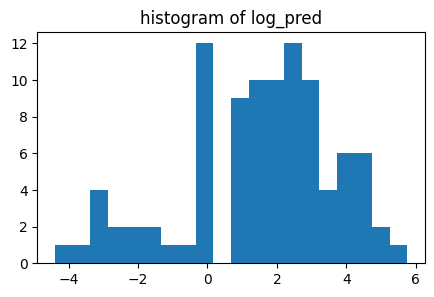

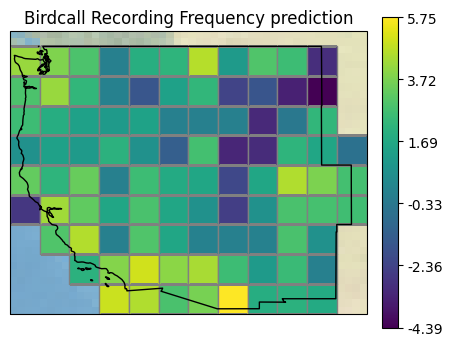

In [198]:
with full_model:
    ppc_full = pm.sample_posterior_predictive(trace_full)

plot_ppc(prep_df, ppc_full, "log_pred")